## Experimental Work and The Transferability Principle
```In this exercise you will experience with real experimental work and will meet a very interesting issue - adversarial AI and the transferability principle. You will define experiments and measures for success, and will execute those experiments. It is of great importance that you will discuss this exercise with your tutor, even during the work on the exercise.```

```~Ohad Amosi & Ittai Haran```

```Read the paper "Adversarial Examples Are Not Bugs, They Are Features", which you can find in this exercise directory. Read it thoroughly. Make sure you understand how the datasets of experiments #1 and #2 were generated. As you might tell, the paper reports very interesting results.```

```If you are not familiar with the concept of model distillation, read about it. There arise the question, how can we be sure that the "non-robust" features described in the paper are real? Could it be that the effect the paper measures is a model distillation? Think about it: In both the experiments the authors used a trained robust network to label images, on which another network was trained normally. Could it be that the robust network was somehow "leaked"? Think about this possibility, and how it could have happen in experiment #1 and experiment #2.```

## Answer

In distillation training, one model is trained to predict the output probabilities of another model that was trained on an earlier, baseline standard to emphasize accuracy.

In the case of the first experiment, robust model is used to create a robust dataset.
We want to replace each sample x in the original dataset by a sample x_r. x and x_r must be very close in the latent space of a robust model.
We use only the representation layer of the robust model, not the output probabilities and then it is not a distillation training. Furthermore, the new sample x_r does not lie in the latent sapce, but in the input space

Experiment #2 does not use a robust model, but creates advresarial example to show that good classification can be achieved only based on non-robust features

```All in all, we will examine two conjectures:```
1. ```The paper is great, non-robust features are the real thing and different networks use the same features.```
2. ```The paper is wrong, it's only a fancy way of network distilling.```

```Let's first explore the concept of distilling networks. Can we do it in any case? Can you distill a network using only, for example, white noise? Can you do it using only the predictions? Or do you maybe need to use the logits of the network? Answer this question. MNIST might help you with that.```

In [1]:
import numpy as np
from keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Layer
import tensorflow as tf

In [2]:
class DivideLayer(Layer):
    def __init__(self, temperature=1, **kwargs):
        self.temperature = temperature
        super(DivideLayer, self).__init__(**kwargs)

    def call(self, inputs, training=None):
        if training:
            return  inputs / self.temperature
        return inputs

In [3]:
def train_model(x_train, y_train, input_shape, num_classes, temperature=1):
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            DivideLayer(temperature),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    
    es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
#     model.summary()
    model.fit(x_train, y_train, batch_size=256, epochs=15, validation_split=0.1, callbacks=[es])
    
    return model

In [4]:
def TestAttack(model, adv_images, orig_images, true_labels, target_labels=None, targeted=False):
    adv_images = adv_images.numpy()
    score = model.evaluate(adv_images, true_labels, verbose=0)
    
    print('Test loss: {:.2f}'.format(score[0]))
    print('Successfully moved out of source class: {:.2f}'.format( 1 - score[1]))
    
    if targeted:
        score = model.evaluate(adv_images, target, verbose=0)
        print('Test loss: {:.2f}'.format(score[0]))
        print('Successfully perturbed to target class: {:.2f}'.format(score[1]))
    
    dist = np.mean(np.sqrt(np.mean(np.square(adv_images - orig_images), axis=(1,2,3))))
    print('Mean perturbation distance: {:.2f}'.format(dist))

In [5]:
def FastGradientSignMethod(model, input_image, input_label, eps=0.3):
    loss_object = tf.keras.losses.CategoricalCrossentropy()
    
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)

    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    adv_x = input_image + eps*signed_grad
    
    return adv_x

In [6]:
def attack_model(test_images, test_labels, model, eps=0.3):
  test_images = tf.convert_to_tensor(test_images)

  adv_images = FastGradientSignMethod(model, test_images, test_labels, eps=eps)
  TestAttack(model, adv_images, test_images.numpy(), test_labels, targeted=False)

In [9]:
def train_distillation(temperature=1, use_proba=True, white_noise_input=False, 
                       number_white_noise=60000):
    num_classes = 10
    input_shape = (28, 28, 1)
    
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

    x_train = x_train.astype("float32") / 255
    x_test = x_test.astype("float32") / 255
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)

    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    print('x_train', x_train.shape)
    print("Training teacher model")
    teacher = train_model(x_train, y_train, input_shape, num_classes, temperature=temperature)
    
    _, acc = teacher.evaluate(x_test, y_test, batch_size=512)
    print('Teacher test accuracy:', acc)

    if use_proba is True:
        train_probas = teacher.predict(x_train)
    else:
        train_probas = teacher.predict(x_train)
        print(train_probas[0, :])
        train_probas = np.argmax(train_probas, axis=1)
        train_probas = tf.one_hot(train_probas, depth=num_classes)
        print(train_probas[0, :])

    if white_noise_input is True:
#         x_train = np.random.normal(size=(60000, 28, 28, 1))
        x_train = np.random.randint(0, 2, size=(number_white_noise, 28, 28, 1))
        train_probas = teacher.predict(x_train)
        print('x_train', x_train.shape)

    print("Training student model")
    student = train_model(x_train, train_probas, input_shape, num_classes, temperature=temperature)
    
    _, acc = student.evaluate(x_test, y_test, batch_size=512)
    print('Student test accuracy:', acc)

    print('Attacking teacher model')
    attack_model(x_test, y_test, teacher, eps=0.3)
    print('Attacking student model')
    attack_model(x_test, y_test, student, eps=0.3)

    return teacher, student

In [ ]:
teacher, student = train_distillation(temperature=10, use_proba=True)

Training teacher model
Epoch 1/15
211/211 [==============================] - 4s 14ms/step - loss: 1.3754 - accuracy: 0.6046 - val_loss: 0.7729 - val_accuracy: 0.9508
Epoch 2/15
211/211 [==============================] - 3s 12ms/step - loss: 0.2553 - accuracy: 0.9234 - val_loss: 0.5619 - val_accuracy: 0.9682
Epoch 3/15
211/211 [==============================] - 3s 13ms/step - loss: 0.1807 - accuracy: 0.9463 - val_loss: 0.4765 - val_accuracy: 0.9753
Epoch 4/15
211/211 [==============================] - 3s 12ms/step - loss: 0.1482 - accuracy: 0.9556 - val_loss: 0.4378 - val_accuracy: 0.9778
Epoch 5/15
211/211 [==============================] - 3s 12ms/step - loss: 0.1249 - accuracy: 0.9623 - val_loss: 0.4146 - val_accuracy: 0.9787
Epoch 6/15
211/211 [==============================] - 3s 12ms/step - loss: 0.1166 - accuracy: 0.9633 - val_loss: 0.3762 - val_accuracy: 0.9808
Epoch 7/15
211/211 [==============================] - 3s 12ms/step - loss: 0.1009 - accuracy: 0.9705 - val_loss: 0.3380

In [ ]:
teacher, student = train_distillation(temperature=10, use_proba=False)

Training teacher model
Epoch 1/15
211/211 [==============================] - 3s 14ms/step - loss: 1.4108 - accuracy: 0.5956 - val_loss: 0.7853 - val_accuracy: 0.9508
Epoch 2/15
211/211 [==============================] - 3s 13ms/step - loss: 0.2501 - accuracy: 0.9278 - val_loss: 0.5431 - val_accuracy: 0.9707
Epoch 3/15
211/211 [==============================] - 3s 13ms/step - loss: 0.1689 - accuracy: 0.9509 - val_loss: 0.4625 - val_accuracy: 0.9770
Epoch 4/15
211/211 [==============================] - 3s 13ms/step - loss: 0.1375 - accuracy: 0.9594 - val_loss: 0.4091 - val_accuracy: 0.9792
Epoch 5/15
211/211 [==============================] - 3s 13ms/step - loss: 0.1164 - accuracy: 0.9648 - val_loss: 0.3756 - val_accuracy: 0.9822
Epoch 6/15
211/211 [==============================] - 3s 13ms/step - loss: 0.1067 - accuracy: 0.9686 - val_loss: 0.3469 - val_accuracy: 0.9830
Epoch 7/15
211/211 [==============================] - 3s 13ms/step - loss: 0.0944 - accuracy: 0.9714 - val_loss: 0.2977

In [10]:
teacher, student = train_distillation(temperature=10, use_proba=True, white_noise_input=True,
                                     number_white_noise=300000)

x_train (60000, 28, 28, 1)
Training teacher model
Epoch 1/15
211/211 [==============================] - 2s 8ms/step - loss: 1.3688 - accuracy: 0.6195 - val_loss: 0.7693 - val_accuracy: 0.9500
Epoch 2/15
211/211 [==============================] - 1s 7ms/step - loss: 0.2487 - accuracy: 0.9263 - val_loss: 0.5327 - val_accuracy: 0.9692
Epoch 3/15
211/211 [==============================] - 1s 7ms/step - loss: 0.1801 - accuracy: 0.9464 - val_loss: 0.4760 - val_accuracy: 0.9742
Epoch 4/15
211/211 [==============================] - 1s 7ms/step - loss: 0.1447 - accuracy: 0.9556 - val_loss: 0.4140 - val_accuracy: 0.9768
Epoch 5/15
211/211 [==============================] - 1s 7ms/step - loss: 0.1257 - accuracy: 0.9624 - val_loss: 0.3993 - val_accuracy: 0.9805
Epoch 6/15
211/211 [==============================] - 1s 7ms/step - loss: 0.1130 - accuracy: 0.9662 - val_loss: 0.3804 - val_accuracy: 0.9830
Epoch 7/15
211/211 [==============================] - 1s 7ms/step - loss: 0.1036 - accuracy: 0.968

```Distilling using only white noise is a though question. Why is it? Think about the concepts of distribution and out-of-distribution in when answering this.```

In [ ]:
"""
Distillition using white noise is tricky. 
When using white noise, most of the train data is not correlated to the real data. 

But there is a small part of the data which will be close to the real data. 
Because we are using the output probabilities of the teacher, the labels will be the right ones.

This small part of the data is out-of-distribution. That's why in this case the student get poor results (0.35), 
but not trivial accuracy (which would be 0.1).
"""

```Assuming conjecture #2 and regarding experiment #1, the distillation isn't happening on white noise, but not on real images either. Think of an experiment that will help you decide if the phenomenon the authors encountered is indeed just network distillation. Think how to measure your success. Open the hint only if you can't think of a way do to it.```

```You can, for example, take a dataset such as CIFAR10, train a network on 5 classes and try to distill it using the other 5 classes. That way you are using real images, but from different distributions.```

In [7]:
from tensorflow.keras import datasets

In [8]:
def train_model(x_train, y_train, input_shape, num_classes, temperature=1):
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            DivideLayer(temperature),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    
    es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.fit(x_train, y_train, batch_size=256, epochs=30, validation_split=0.1, callbacks=[es])
    
    return model

In [17]:
def train_distillation(temperature=1):
    num_classes = 10
    input_shape = (32, 32, 3)
    
    (train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
    train_images, test_images = train_images / 255.0, test_images / 255.0

    print('train_labels', train_labels.shape)
    print('train_images', train_images.shape)

    indices_train = train_labels < 5
    indices_train = indices_train.reshape(indices_train.shape[0])

    x_train_teacher = train_images[indices_train, :, :, :]
    y_train_teacher = train_labels[indices_train]

    indices_train = train_labels >= 5
    indices_train = indices_train.reshape(indices_train.shape[0])

    x_train_student = train_images[indices_train, :, :, :]
    y_train_student = train_labels[indices_train]
    y_train_student -= 5

    indices_test = test_labels < 5
    indices_test = indices_test.reshape(indices_test.shape[0])

    x_test = test_images[indices_test, :, :, :]
    y_test = test_labels[indices_test]

    y_train_teacher = keras.utils.to_categorical(y_train_teacher, 5)
    y_train_student = keras.utils.to_categorical(y_train_student, 5)
    y_test = keras.utils.to_categorical(y_test, 5)

    print('x_train_teacher', x_train_teacher.shape)
    print('y_train_teacher', y_train_teacher.shape)
    print('x_train_student', x_train_student.shape)
    print('y_train_student', y_train_student.shape)
    print('x_test', x_test.shape)
    print('y_test', y_test.shape)

    print("Training teacher model")
    teacher = train_model(x_train_teacher, y_train_teacher, input_shape, num_classes=5, temperature=temperature)
    
    _, acc = teacher.evaluate(x_test, y_test, batch_size=512)
    print('Teacher test accuracy:', acc)

    train_probas = teacher.predict(x_train_student)

    print("Training student model")
    student = train_model(x_train_student, train_probas, input_shape, num_classes=5, temperature=temperature)
    
    _, acc = student.evaluate(x_test, y_test, batch_size=512)
    print('Student test accuracy:', acc)

    print('Attacking teacher model')
    attack_model(x_test, y_test, teacher, eps=0.3)
    print('Attacking student model')
    attack_model(x_test, y_test, student, eps=0.3)

    return teacher, student

In [18]:
teacher, student = train_distillation(temperature=20)

train_labels (50000, 1)
train_images (50000, 32, 32, 3)
x_train_teacher (25000, 32, 32, 3)
y_train_teacher (25000, 5)
x_train_student (25000, 32, 32, 3)
y_train_student (25000, 5)
x_test (5000, 32, 32, 3)
y_test (5000, 5)
Training teacher model
Epoch 1/30
88/88 [==============================] - 1s 12ms/step - loss: 1.5598 - accuracy: 0.2869 - val_loss: 6.0994 - val_accuracy: 0.4480
Epoch 2/30
88/88 [==============================] - 1s 9ms/step - loss: 1.3203 - accuracy: 0.4701 - val_loss: 7.4416 - val_accuracy: 0.5244
Epoch 3/30
88/88 [==============================] - 1s 9ms/step - loss: 1.1786 - accuracy: 0.5278 - val_loss: 6.7480 - val_accuracy: 0.5776
Epoch 4/30
88/88 [==============================] - 1s 9ms/step - loss: 1.0954 - accuracy: 0.5654 - val_loss: 6.8627 - val_accuracy: 0.5984
Epoch 5/30
88/88 [==============================] - 1s 10ms/step - loss: 1.0434 - accuracy: 0.5800 - val_loss: 7.0633 - val_accuracy: 0.5984
Epoch 6/30
88/88 [==============================] - 1

```Let's focus now on conjecture #1. Conduct an experiment that will demonstrate that two different networks indeed use the same features. Do it gradually: Start with two copies of the same architecture and on the same data, and move to different architectures and different subsets of the data (but from the same distribution). Think how to measure your success.```

In [34]:
from keras.models import Model
from keras.layers import Input, Embedding, Dense, concatenate, Flatten

def train_model(x_train, y_train, input_shape, num_classes, model_1 = True):
  x_input = keras.Input(shape=input_shape)
  if model_1 is True:
    x = layers.Conv2D(32, kernel_size=(4, 4), activation="relu")(x_input)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(32, kernel_size=(4, 4), activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)
    features = layers.Dropout(0.5)(x)
  else:
    x = layers.Flatten()(x_input)
    features = layers.Dense(512, activation='relu')(x)

  predictions = layers.Dense(num_classes, activation="softmax")(features)
  
  model = Model(inputs = x_input, outputs = predictions)
  features_model = Model(inputs=x_input, outputs=features)

  es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3)
  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
  model.fit(x_train, y_train, batch_size=256, epochs=15, validation_split=0.1, callbacks=[es])
  # print(model.summary())
  return model, features_model

In [35]:
num_classes = 10
input_shape = (28, 28, 1)

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model_1, features_model_1 = train_model(x_train, y_train, input_shape, num_classes, model_1=True)
model_2, features_model_2 = train_model(x_train, y_train, input_shape, num_classes, model_1=False)

_, acc_1 = model_1.evaluate(x_test, y_test, batch_size=512)
_, acc_2 = model_2.evaluate(x_test, y_test, batch_size=512)

print('acc_1', acc_1, 'acc_2', acc_2)

Epoch 1/15
211/211 [==============================] - 3s 11ms/step - loss: 1.1393 - accuracy: 0.6225 - val_loss: 0.1226 - val_accuracy: 0.9648
Epoch 2/15
211/211 [==============================] - 2s 10ms/step - loss: 0.2091 - accuracy: 0.9376 - val_loss: 0.0747 - val_accuracy: 0.9798
Epoch 3/15
211/211 [==============================] - 2s 10ms/step - loss: 0.1428 - accuracy: 0.9564 - val_loss: 0.0654 - val_accuracy: 0.9830
Epoch 4/15
211/211 [==============================] - 2s 10ms/step - loss: 0.1195 - accuracy: 0.9636 - val_loss: 0.0566 - val_accuracy: 0.9845
Epoch 5/15
211/211 [==============================] - 2s 10ms/step - loss: 0.1014 - accuracy: 0.9685 - val_loss: 0.0463 - val_accuracy: 0.9870
Epoch 6/15
211/211 [==============================] - 2s 10ms/step - loss: 0.0865 - accuracy: 0.9738 - val_loss: 0.0443 - val_accuracy: 0.9875
Epoch 7/15
211/211 [==============================] - 2s 10ms/step - loss: 0.0792 - accuracy: 0.9755 - val_loss: 0.0416 - val_accuracy: 0.9893

In [36]:
features_1 = features_model_1.predict(x_test)
features_2 = features_model_2.predict(x_test)

In [37]:
print(features_1.shape)
print(features_2.shape)

(10000, 512)
(10000, 512)


In [41]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(features_1, features_2))

print(np.sum(np.abs(features_1)) / features_1.shape[0])
print(np.sum(np.abs(features_2)) / features_1.shape[0])

0.70679104
216.6538
262.9273


In [39]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(features_1, features_2)

print(reg.score(features_1, features_2))

0.8732108958871897


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [42]:
predict_features_2 = reg.predict(features_1)
print(mean_absolute_error(predict_features_2, features_2))

0.18124165


In [48]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

scaler_model_1 = MinMaxScaler()
pca_model_1 = PCA(n_components = 3)
features_1_new = pca_model_1.fit_transform(scaler_model_1.fit_transform(features_1))

scaler_model_2 = MinMaxScaler()
pca_model_2 = PCA(n_components = 3)
features_2_new = pca_model_2.fit_transform(scaler_model_2.fit_transform(features_2))

In [49]:
features_1_new.shape

(10000, 3)

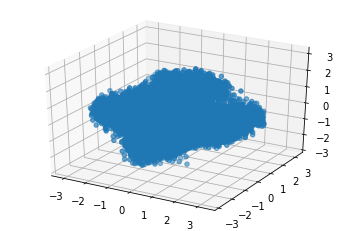

In [50]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(features_1_new[:, 0], features_1_new[:, 1], features_1_new[:, 2])

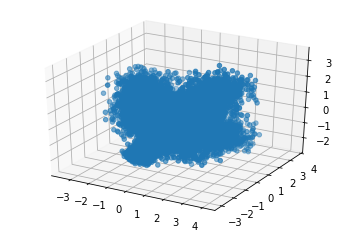

In [51]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(features_2_new[:, 0], features_2_new[:, 1], features_2_new[:, 2])

In [52]:
scaler_model_1 = MinMaxScaler()
pca_model_1 = PCA(n_components = 2)
features_1_new = pca_model_1.fit_transform(scaler_model_1.fit_transform(features_1))

scaler_model_2 = MinMaxScaler()
pca_model_2 = PCA(n_components = 2)
features_2_new = pca_model_2.fit_transform(scaler_model_2.fit_transform(features_2))

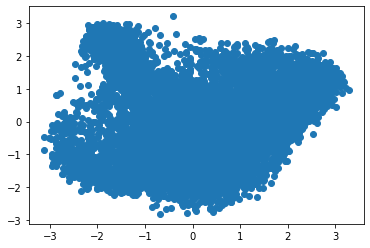

In [53]:
plt.figure()
plt.scatter(features_1_new[:, 0], features_1_new[:, 1])
plt.show()

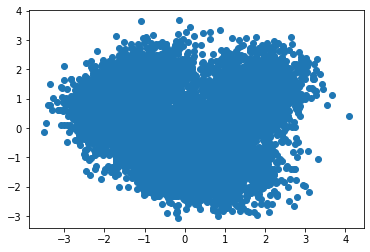

In [54]:
plt.figure()
plt.scatter(features_2_new[:, 0], features_2_new[:, 1])
plt.show()

In [55]:
scaler_model_1 = MinMaxScaler()
pca_model_1 = PCA(n_components = 512)
features_1_new = pca_model_1.fit_transform(scaler_model_1.fit_transform(features_1))

scaler_model_2 = MinMaxScaler()
pca_model_2 = PCA(n_components = 512)
features_2_new = pca_model_2.fit_transform(scaler_model_2.fit_transform(features_2))

print(mean_absolute_error(features_1_new, features_2_new))

0.10685529


In [59]:
features_1_new = [x for _, x in sorted(zip(pca_model_1.explained_variance_, features_1_new), key=lambda pair: pair[0])]
features_2_new = [x for _, x in sorted(zip(pca_model_2.explained_variance_, features_2_new), key=lambda pair: pair[0])]

In [60]:
print(mean_absolute_error(features_1_new, features_2_new))

0.10527064


In [72]:
from tqdm import tqdm

features_1 = features_model_1.predict(x_test)
features_2 = features_model_2.predict(x_test)

num_features = features_1.shape[1]

all_corr = []
for i in tqdm(range(num_features)):
  max_corr = 0
  for j in range(num_features):
    corr_i_j = np.corrcoef(features_1[:, i], features_2[:, j])
    corr_i_j = corr_i_j[0, 1]
    if np.abs(corr_i_j) > max_corr:
      max_corr = np.abs(corr_i_j)
  all_corr.append(max_corr)

  0%|          | 0/512 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|██████████| 512/512 [01:29<00:00,  5.73it/s]

0.6870257854847166


In [73]:
print(np.mean(all_corr))

0.6870257854847166


In [75]:
features_1 = features_model_1.predict(x_test)
features_2 = features_model_2.predict(x_test)

scaler_model_1 = MinMaxScaler()
features_1 = scaler_model_1.fit_transform(features_1)

scaler_model_2 = MinMaxScaler()
features_2 = scaler_model_2.fit_transform(features_2)

num_features = features_1.shape[1]

all_corr = []
for i in tqdm(range(num_features)):
  max_corr = 0
  for j in range(num_features):
    corr_i_j = np.corrcoef(features_1[:, i], features_2[:, j])
    corr_i_j = corr_i_j[0, 1]
    if np.abs(corr_i_j) > max_corr:
      max_corr = np.abs(corr_i_j)
  all_corr.append(max_corr)

  0%|          | 0/512 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|██████████| 512/512 [01:22<00:00,  6.19it/s]


In [76]:
print(np.mean(all_corr))

0.6870257854543358
